#**Homework 04**
##IANNWTF - CNN
###Group 02

In this notebook we implement a Convolutional Neural Network (CNN) using keras and train it on the [Malaria dataset](https://www.tensorflow.org/datasets/catalog/malaria) in order to automatically detect malaria given a set of blood cell images. 

In [ ]:
import numpy as np
%tensorflow_version 2.x
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
print(tf.__version__)

2.3.0


##**1. Load data**
The Malaria dataset contains a total of 27.558 colored images of cells with equal shares of malaria-infected cells and uninfected cells. In order to build or model and train it to detect malaria, we will split the data taking the 80% of it for training and 20% for testing. 

In [ ]:
# Load the dataset and specify the amount of data to be used
malaria_dataset, info = tfds.load('malaria', split='train', shuffle_files=True, with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/malaria/1.0.0.incompleteAE4LNQ/malaria-train.tfrecord


Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


###**1.1 Preprocessing**
For better handling of the datasets, we will convert the extracted malaria_dataset into numpy and extact the respective images and the labels.

In [ ]:
# Convert malaria_dataset into numpy and get images and labels
malaria_dataset_np = tfds.as_numpy(malaria_dataset)
images_pre = []
labels_pre = []

for element in malaria_dataset_np:
  images_pre.append(element['image'])
  labels_pre.append(element['label'])

In [ ]:
# Let's check we have all our images and labels
print(f' \n Total trainning images: {len(images_pre)}, and total labels: {len(labels_pre)}')

# Here we look at the shape of some of the training images as well as their respectice label
for i in range(3):
  print(f'\n Image shape: {images_pre[i].shape}, label: {labels_pre[i]}')

 
 Total trainning images: 27558, and total labels: 27558

 Image shape: (145, 148, 3), label: 1

 Image shape: (133, 127, 3), label: 1

 Image shape: (118, 118, 3), label: 0


###**1.2 Plot some initial images**

In order to get a better understanding of the images and their size, we decided to visualize some of them. As we can see images have different sizes and we will have to resize them since this is necessary to later on being able to feed them into our model.


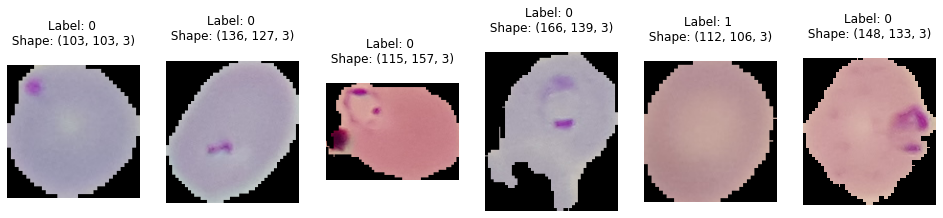

In [ ]:
# Create a plot of six set images 
fig, ax = plt.subplots(1,6, figsize = (12,10))

for i in range(6):
    # take an image, its label and corresponding shape.
    img = images_pre[i]
    lbl = labels_pre[i]
    shp = images_pre[i].shape

    # plot the image and corresponding information
    ax[i].imshow(img)
    ax[i].title.set_text(f'Label: {lbl} \n Shape: {shp} \n')
    ax[i].axis("off")
    plt.subplots_adjust(right = 1.2)

###**1.3 Relevant preprocessing steps**
As we saw before, we have to do some important preprocessing steps such as normalizing and resizing the images. For simplicity, we take the initial malaria_dataset, convert it into numpy, apply the respective steps and safe both images and labels.

In [ ]:
images = []
labels = []
for elem in tfds.as_numpy(malaria_dataset):
  # Convert between data types, scaling the values appropriately before casting
  # This puts the image values in range between 0 and 1 for float conversion
  image = tf.image.convert_image_dtype(elem['image'], tf.float32)
  # resize with padding 
  images.append(tf.image.resize_with_pad(image, target_height=100, target_width=100))
  labels.append(elem['label'])

In [ ]:
# Here we can check that the images are normalized and their values range between 0 and 1
print(f'The minimun in this image is: {np.min(images[0])},\n maximiun is: {np.max(images[0])}')

The minimun in this image is: 0.0,
 maximiun is: 0.7697843909263611


Now we visualize some of the images to make sure they all have the same shape. 

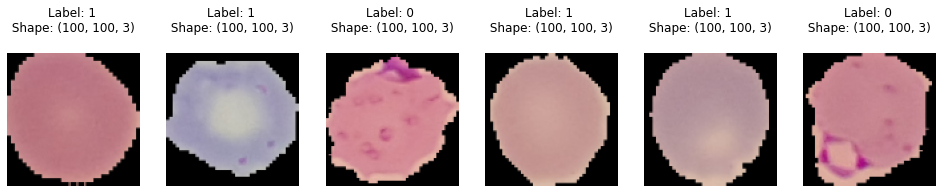

In [ ]:
# Create a plot of six set images 
fig, ax = plt.subplots(1,6, figsize = (12,10))

for i in range(6):
    # take an image, its label and corresponding shape.
    img = images[i]
    lbl = labels[i]
    shp = images[i].shape

    # plot the image and corresponding information
    ax[i].imshow(img)
    ax[i].title.set_text(f'Label: {lbl} \n Shape: {shp} \n')
    ax[i].axis("off")
    plt.subplots_adjust(right = 1.2)

###**1.4 Split the data**
Now, with all images and all labels being normalized and having the same size, we split them in two parts: a training and a testing set of images and labels. 

In [ ]:
# Create training and test dataset incl. tensors
cutoff = round(0.8*len(images))
train_images = images[:cutoff]
train_labels = labels[:cutoff]
test_images = images[cutoff:]
test_labels = labels[cutoff:]


##**2. Build the Tensorflow dataset: Input pipeline**

In [ ]:
# 1. Create a tf.dataset train_dataset_images from a train tensor train_images
train_dataset_images = tf.data.Dataset.from_tensor_slices(train_images)

#  Create a tf.dataset train_dataset_labels from a train tensor train_labels
train_dataset_labels = tf.data.Dataset.from_tensor_slices(train_labels)
# we want the labels to be onehot encoded
train_dataset_labels = train_dataset_labels.map(lambda t : tf.one_hot(t, 2))

# zip together input and labels
train_dataset = tf.data.Dataset.zip((train_dataset_images, train_dataset_labels))
train_dataset = train_dataset.shuffle(buffer_size=128)
train_dataset = train_dataset.batch(128)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

# 2. repeat for test dataset

test_dataset_images = tf.data.Dataset.from_tensor_slices(test_images)


test_dataset_labels = tf.data.Dataset.from_tensor_slices(test_labels)
test_dataset_labels = test_dataset_labels.map(lambda t : tf.one_hot(t, 2))

# zip together both input and labels 
test_dataset = tf.data.Dataset.zip((test_dataset_images, test_dataset_labels))
test_dataset = test_dataset.shuffle(buffer_size=128)
test_dataset = test_dataset.batch(128)
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
# Check for the size of the images since this will be the input_shape for out first Conv2D
for (img,_) in test_dataset:
    print(img.shape)
    break;

(128, 100, 100, 3)


##**3. Build the model**

In the following steps we will implement a Convolutional Neural Network in order to do the classification of the cells. First, we will implement a fully connected feedforward network. 
For our network we we will use:


*   **Input layer:** Conv2D with 32 filters, (3x3) kernel, activation = relu
*   **Hidden Layer 1:** Conv2D with 64 filters, (3x3) kernel, activation = relu
*   **MaxPool2D(2,2)**
*   **Hidden Layer 2:** Conv2D with 128 filters, (3x3) kernel, activation = relu
*   **MaxPool2D(2,2)**
*   **Hidden Layer 3:** Conv2D with 160 filters, (3x3) kernel, activation = relu
*   **MaxPool2D(2,2)**
*   **Hidden Layer 4:** Conv2D with 160 filters, (3x3) kernel, activation = relu
*   **MaxPool2D(2,2)**
*   **GlobalAveragePooling2D**
*   **Output layer:** Dense with 2 filters, activation = softmax









In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

class Model(Model): 
    
    def __init__(self):
        super(Model, self).__init__()
        # Define the layers as follows:
        self.conv_1 = tf.keras.layers.Conv2D(filters=32, kernel_size=3,
                                               activation=tf.keras.activations.relu,
                                               input_shape=(100,100,3)
                                               )
        self.max_pool_1 = tf.keras.layers.MaxPool2D(2,2)
        self.conv_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=3,
                                               activation=tf.keras.activations.relu,
                                               )
        self.max_pool_2 = tf.keras.layers.MaxPool2D(pool_size=(2,2))

        self.conv_3 = tf.keras.layers.Conv2D(filters=128, kernel_size=3,
                                               activation=tf.keras.activations.relu,
                                               )
        self.max_pool_3 = tf.keras.layers.MaxPool2D(pool_size=(2,2))

        self.conv_4 = tf.keras.layers.Conv2D(filters=160, kernel_size=3,
                                               activation=tf.keras.activations.relu,
                                                )
        self.max_pool_4 = tf.keras.layers.MaxPool2D(pool_size=(2,2))

        self.conv_5 = tf.keras.layers.Conv2D(filters=160, kernel_size=3,
                                               activation=tf.keras.activations.relu,
                                                )
        self.max_pool_5 = tf.keras.layers.MaxPool2D(pool_size=(2,2))

        self.global_pool = tf.keras.layers.GlobalAveragePooling2D()

        self.output_layer = tf.keras.layers.Dense(2,
                                                  activation=tf.keras.activations.softmax)

    @tf.function
    def call(self, x):
        # Define the forward step.
        x = self.conv_1(x)
        x = self.max_pool_1(x)
        x = self.conv_2(x)
        x = self.max_pool_2(x)
        x = self.conv_3(x)
        x = self.max_pool_3(x)
        x = self.conv_4(x)
        x = self.max_pool_4(x)
        x = self.conv_5(x)
        x = self.max_pool_5(x)
        x = self.global_pool(x)
        x = self.output_layer(x)
        return x

###**4. Train the Model**

In [ ]:
def train_step(model, input, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss 

def test(model, test_data, loss_function):
  # test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss, test_accuracy
  

In [ ]:
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 20
learning_rate = 0.0001
running_average_factor = 0.95

# Initialize the model.
model = Model()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.BinaryCrossentropy()
# Initialize the optimizer: Adam with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize lists for later visualization.
train_losses = []

test_losses = []
test_accuracies = []

#testing once before we begin
test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, _ = test(model, train_dataset, cross_entropy_loss)
train_losses.append(train_loss)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print('Epoch: __ ' + str(epoch))

    train_dataset = train_dataset.shuffle(buffer_size=128)
    test_dataset = test_dataset.shuffle(buffer_size=128)

    #training (and checking in with training)
    running_average = 0
    for (input,target) in train_dataset:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
    train_losses.append(running_average)

    #testing
    test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)



Epoch: __ 0
Epoch: __ 1
Epoch: __ 2
Epoch: __ 3
Epoch: __ 4
Epoch: __ 5
Epoch: __ 6
Epoch: __ 7
Epoch: __ 8
Epoch: __ 9
Epoch: __ 10
Epoch: __ 11
Epoch: __ 12
Epoch: __ 13
Epoch: __ 14
Epoch: __ 15
Epoch: __ 16
Epoch: __ 17
Epoch: __ 18
Epoch: __ 19


###**5. Visualizing the Process**
Finally, we can visualize the accuracy and loss for both training test data.

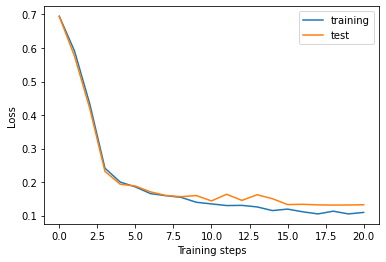

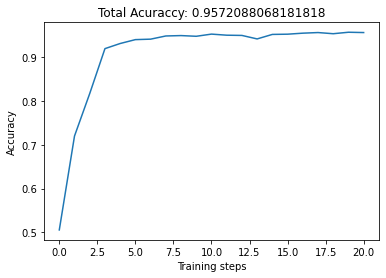

In [ ]:
# Plot training and test loss.
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1,line2),("training","test"))
plt.show()

# Plot training and test accuracy.
plt.figure()
line1, = plt.plot(test_accuracies)
plt.title(f'Total Acuraccy: {np.max(test_accuracies)}')
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.show()

## Save the Model
Finally, we will save our model given its great performance. This way we can keep all the para meters it has learn so far (such as weights) so that we can use them later on.

In [ ]:
model.save_weights('malaria_cnn.h5')